In [138]:
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
import random
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [139]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 44  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings

In [140]:
questions_df = pd.read_csv('question-pairs-dataset/questions.csv')

In [141]:
questions_data = list(questions_df['question1'])

In [142]:
questions_data = questions_data[:10664]

In [143]:
print(len(questions_data))

10664


In [144]:
with open('positive-and-negative-sentences/positive.txt','rb') as file:
    data_pos = file.read().decode(errors='replace')
data_pos = data_pos.split('\n')
with open('positive-and-negative-sentences/negative.txt','rb') as file:
    data_neg = file.read().decode(errors='replace')
data_neg = data_neg.split('\n')

In [145]:
non_questions_data = data_pos+data_neg
random.shuffle(non_questions_data)
non_questions_data

["for all the writhing and wailing , tears , rage and opium overdoses , there's no sense of actual passion being washed away in love's dissolution . ",
 'the parts are better than the whole ( bizarre , funny , tragic - like love in new york ) . ',
 "gambling and throwing a basketball game for money isn't a new plot    in fact toback himself used it in black and white . but toback's deranged immediacy makes it seem fresh again . ",
 'is not so much a work of entertainment as it is a unique , well crafted psychological study of grief . ',
 "not only is undercover brother as funny , if not more so , than both austin powers films , but it's also one of the smarter , savvier spoofs to come along in some time . ",
 'wilco fans will have a great time , and the movie should win the band a few new converts , too . ',
 'the heightened symmetry of this new/old cinema paradiso makes the film a fuller experience , like an old friend haunted by the exigencies of time . ',
 "it's funny , touching , d

In [146]:
len(non_questions_data)

10664

In [147]:
questions_data_labels = list(np.ones(len(questions_data)))
non_questions_data_labels = list(np.zeros(len(non_questions_data)))

In [148]:
X_1 = questions_data + non_questions_data
Y_1 = questions_data_labels + non_questions_data_labels



In [149]:
X,Y = shuffle(X_1,Y_1,random_state=1)


In [150]:
X = np.array(X)
Y = np.array(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=31)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 19195
# Test data samples: 2133


In [151]:
X_train1 = X_train
X_test1 = X_test
y_train1 = y_train
y_test1 = y_test

In [152]:


#X_test = np.append(X_test,[[["I am leaving I'll see you on the other side"]]])


#stopwords_list = stopwords.words('english')


#for i in range(len(X_train)):
#    l = [word for word in X_train[i].split() if(word not in stopwords_list) and len(word)>1]
#    X_train[i] = " ".join(l)
#for i in range(len(X_test)):
#    l = [word for word in X_test[i].split() if(word not in stopwords_list) and len(word)>1]
#    X_test[i] = " ".join(l)
    


In [153]:
print(X_test.shape)

(2133,)


In [154]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)


In [155]:
seq_lengths = pd.Series(X_train).apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    19195.000000
mean        16.605679
std          9.606677
min          1.000000
25%          9.000000
50%         14.000000
75%         23.000000
max         66.000000
dtype: float64

In [156]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [157]:
X_train_seq_trunc[10]  # Example of padded sequence

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    2, 5051, 6012,
       1133,   47,    6, 3118, 2094, 1285, 7354,   59,   92,   12,  321,
          6,   29,   88, 7355,   64,   83,  419,  218, 9519,    6, 7356],
      dtype=int32)

In [158]:
print(y_train)

[0. 0. 0. ... 0. 1. 1.]


In [159]:
le = LabelEncoder()
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [160]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (1920, 44)


## WITHOUT GLOVE ##

In [161]:
emb_model = models.Sequential()
#emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))      100d vector works better
emb_model.add(layers.Embedding(NB_WORDS, 100, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 44, 100)           1000000   
_________________________________________________________________
flatten_9 (Flatten)          (None, 4400)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 8802      
Total params: 1,008,802
Trainable params: 1,008,802
Non-trainable params: 0
_________________________________________________________________


In [162]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()


In [163]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
emb_history.history['acc'][-1]

0.9983212735166426

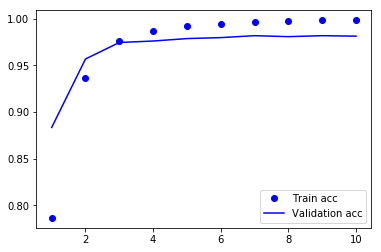

In [164]:
eval_metric(emb_history, 'acc')

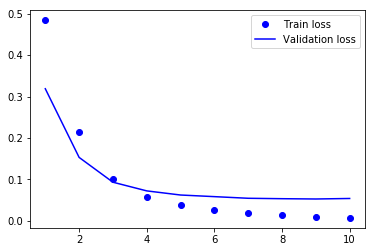

In [165]:
eval_metric(emb_history, 'loss')

In [166]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results


In [167]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

2133/2133 [==============================] - 0s 29us/step
/n
Test accuracy of word embeddings model: 98.17%


In [168]:
#print(X_train_seq_trunc[1])
print(X_train1[10:20])
print(X_train1[15])

['a fragile framework upon which to hang broad , mildly fleshed-out characters that seem to have been conjured up only 10 minutes prior to filming . '
 "the film is saved from aren't kids cute sentimentality by a warmth that isn't faked and a stately sense of composition . "
 'blessed with two fine , nuanced lead performances . '
 'What are some thoughts about death?'
 ' . . . pitiful , slapdash disaster . a doa dud from frame one . '
 'What are good methods to study engineering?'
 "How is the word 'ubiquitous' used in a sentence?"
 'What is the balanced chemical equation for the formation of soap scum?'
 'desperately unfunny when it tries to makes us laugh and desperately unsuspenseful when it tries to make us jump out of our seats . '
 'How could we know that we are falling in love?']
What are good methods to study engineering?


In [169]:
emb_model.predict_classes([[X_train_seq_trunc[15]]])

array([1])

In [211]:
#sentence = "in some text books on microeconomics there is a graph of demand and supply that are based on producer and consumer theory. How do these graphs are interpreted-because they are all over the book"
sentence = "Model can identify is a sentence is a question"
#sentence_nstop = " ".join([word for word in sentence.split() if(word not in stopwords_list) and len(word)>1])
sentence_nstop = [sentence]
sentence_nstop = np.array(sentence_nstop)
sentence_seq = tk.texts_to_sequences(sentence_nstop)
sentence_seq_trunc = pad_sequences(sentence_seq, maxlen=MAX_LEN)
print(sentence_seq_trunc)



[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 2295   19 3712    5    2 2313    5
     2  360]]


In [212]:
res = emb_model.predict(sentence_seq_trunc)
print(res)
print(res[0][1])

[[6.1557516e-06 9.9999380e-01]]
0.9999938


In [200]:
#Works better on long sentences
#Some sentences to check:
#i) "This works great. Model runs good"
#ii)"Yup, it does work better on long sentences"

#Some bad results
#i) "Model can identify if the given sentence is a question"#DEEEEEP
#ii)"Where there is a will there is a way"
#Try with glove vectors next

## USING GLOVE ##

Download Link: http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [202]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open('glove.twitter.27B/'+ glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [204]:
emb_dict['how']

array([ 5.2448e-01,  1.4927e-01,  6.4005e-01,  2.0525e-01, -3.0022e-01,
        2.9393e-01,  2.8445e-01, -3.9302e-01,  4.2924e-01,  1.9822e-01,
       -2.7205e-01, -4.2461e-01, -5.7456e+00, -4.7719e-03, -9.2842e-02,
       -4.7557e-01,  2.5792e-02, -4.9820e-01,  3.8240e-02, -2.4317e-02,
        4.3822e-01, -2.4423e-01, -2.3782e-01,  3.9505e-01,  2.8254e-02,
        1.3690e-01,  2.7915e-04,  6.2020e-01,  3.6447e-01, -3.9848e-01,
       -3.7173e-01, -1.4106e-02, -1.8491e-01,  3.1630e-01, -2.5656e-01,
        2.7244e-01, -1.6537e-01,  1.6202e-01, -7.2154e-02, -3.1059e-01,
       -6.2878e-01, -5.6730e-02,  4.5687e-01,  4.9870e-01,  1.3140e-01,
        1.9770e-01, -1.4396e-01, -1.5598e-01, -1.0978e-01, -1.6734e-01,
       -1.9454e-01, -1.0928e-02, -1.2794e-01,  2.7448e-02,  6.0323e-01,
        4.6323e-01, -6.7122e-01,  4.2575e-02, -2.5487e-02, -8.2335e-02,
        3.6152e-02, -1.2599e-01,  1.5335e-01, -6.2048e-01,  3.4524e-01,
        2.2140e-01, -5.0268e-01,  3.5937e-02, -1.0611e-01,  3.05

In [205]:

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break


In [206]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
#glove_model.add(layers.Flatten())
#glove_model.add(layers.Dense(1000,activation='tanh'))          #found that hidden layer results in overfitting
#glove_model.add(layers.LSTM(200, dropout_U = 0.2, dropout_W = 0.2))
glove_model.add(layers.Dense(2, activation='softmax'))
glove_model.summary()

/home/mayank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 44, 100)           1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 402       
Total params: 1,241,202
Trainable params: 1,241,202
Non-trainable params: 0
_________________________________________________________________


In [207]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [126]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
glove_history.history['acc'][-1]

0.9833863970822777

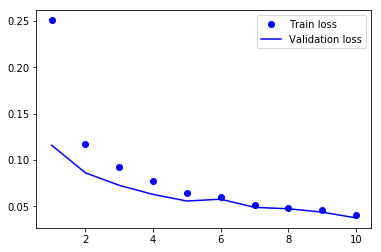

In [127]:
eval_metric(glove_history, 'loss')

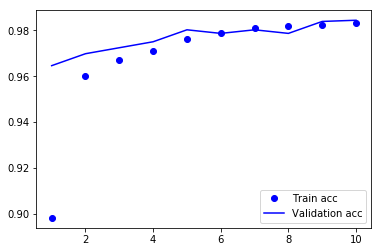

In [128]:
eval_metric(glove_history, 'acc')


In [129]:

glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

2133/2133 [==============================] - 2s 717us/step
/n
Test accuracy of word glove model: 98.59%


In [133]:
def predict_if_question(sentence):
    sentence_nstop = " ".join([word for word in sentence.split() if(word not in stopwords_list) and len(word)>1])
    print(sentence)
    sentence_nstop = [sentence_nstop]
    sentence_nstop = np.array(sentence_nstop)
    print(sentence_nstop)
    sentence_seq = tk.texts_to_sequences(sentence_nstop)
    print(sentence_seq)
    sentence_seq_trunc = pad_sequences(sentence_seq, maxlen=MAX_LEN)
    print(sentence_seq_trunc)
    return glove_model.predict(sentence_seq_trunc)

In [134]:
predict_if_question("You are going to the park arent you")

You are going to the park arent you
['You going park arent']
[[414, 112, 1734]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  414
   112 1734]]


array([[0.02369482, 0.9763051 ]], dtype=float32)

In [135]:
predict_if_question("what are intangible assets?")

what are intangible assets?
['intangible assets?']
[[]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0]]


array([[0.5663282 , 0.43367177]], dtype=float32)